In [19]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings("ignore")

In [20]:
import time
import gc

In [21]:
import STAGATE_pyG as STAGATE

In [22]:
path='/home/workspace/zhaofangyuan/Data'
adata = sc.read_h5ad(f'{path}/aging.h5ad')

In [23]:
adata

AnnData object with n_obs × n_vars = 378918 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'slice_id', 'ct', 'ct_sub'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'batch_condition', 'cell_type_colors', 'schema_version', 'title'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'spatial'

In [24]:
adata.obs['slice_id'] = adata.obs['slice_id'].astype('category')
adata.obs['ct'] = adata.obs['ct'].astype('category')

In [25]:
adata.obs['slice_id'].cat.categories

Index(['MsBrainAgingSpatialDonor_10_0', 'MsBrainAgingSpatialDonor_10_1',
       'MsBrainAgingSpatialDonor_10_2', 'MsBrainAgingSpatialDonor_11_0',
       'MsBrainAgingSpatialDonor_11_1', 'MsBrainAgingSpatialDonor_11_2',
       'MsBrainAgingSpatialDonor_12_0', 'MsBrainAgingSpatialDonor_12_1',
       'MsBrainAgingSpatialDonor_1_0', 'MsBrainAgingSpatialDonor_2_0',
       'MsBrainAgingSpatialDonor_2_1', 'MsBrainAgingSpatialDonor_3_0',
       'MsBrainAgingSpatialDonor_3_1', 'MsBrainAgingSpatialDonor_4_0',
       'MsBrainAgingSpatialDonor_4_1', 'MsBrainAgingSpatialDonor_4_2',
       'MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_5_1',
       'MsBrainAgingSpatialDonor_5_2', 'MsBrainAgingSpatialDonor_6_0',
       'MsBrainAgingSpatialDonor_6_1', 'MsBrainAgingSpatialDonor_6_2',
       'MsBrainAgingSpatialDonor_7_0', 'MsBrainAgingSpatialDonor_7_1',
       'MsBrainAgingSpatialDonor_7_2', 'MsBrainAgingSpatialDonor_8_0',
       'MsBrainAgingSpatialDonor_8_1', 'MsBrainAgingSpatialDonor_8_2'

In [26]:
# Select slice
import anndata as ad
adata_raw0=adata[adata.obs['slice_id']=='MsBrainAgingSpatialDonor_11_0']
adata_raw1=adata[adata.obs['slice_id']=='MsBrainAgingSpatialDonor_11_1']
adata_raw2=adata[adata.obs['slice_id']=='MsBrainAgingSpatialDonor_11_2']
# adata_raw3=adata[adata.obs['slice_id']=='MsBrainAgingSpatialDonor_10_0']
# adata_raw4=adata[adata.obs['slice_id']=='MsBrainAgingSpatialDonor_10_1']
adatas=[adata_raw0,adata_raw1,adata_raw2]
adatas = ad.concat(adatas)

adatas.obs['slice_id'] = adatas.obs['slice_id'].astype('category')
adatas.obs['ct'] = adatas.obs['ct'].astype('category')

In [27]:
adata_raw = adatas.copy()

In [28]:
n_cls = np.unique(adatas.obs['tissue']).shape[0]
# n_cls=8

In [29]:
# def mclust_P(adata, num_cluster, used_obsm='STAGATE', modelNames='EEE'):
    
#     from sklearn import mixture
#     np.random.seed(2020)
#     g = mixture.GaussianMixture(n_components=num_cluster, covariance_type='diag')
#     res = g.fit_predict(adata.obsm[used_obsm])
#     adata.obs['mclust'] = res
#     return adata

------Calculating spatial graph...
The graph contains 137226 edges, 7545 cells.
18.1877 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 256326 edges, 14195 cells.
18.0575 neighbors per cell on average.
Size of Input:  (21740, 374)


100%|██████████| 1500/1500 [02:11<00:00, 11.43it/s]


29973

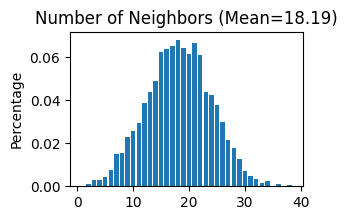

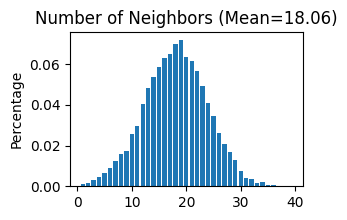

In [30]:
import tracemalloc
tracemalloc.start()  

time_st = time.time()
adata = adata_raw.copy()

adata.obs['slice_id'] = adata.obs['slice_id'].astype('category')
slice_list = adata.obs['slice_id'].cat.categories
adata_list = []
for s in slice_list:
    cur_a = adata[adata.obs['slice_id']==s]
    adata_list.append(cur_a)
for i in range(len(slice_list)):
    STAGATE.Cal_Spatial_Net(adata_list[i], rad_cutoff=70)
    STAGATE.Stats_Spatial_Net(adata_list[i])
adata = sc.concat(adata_list, keys=None)
adata.uns['Spatial_Net'] = pd.concat([adata_list[i].uns['Spatial_Net'] for i in range(len(adata_list))])



adata = STAGATE.train_STAGATE(adata,random_seed=0,n_epochs=1500)
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

# adata = mclust_P(adata, used_obsm='STAGATE', num_cluster=n_cls)
# os.environ['R_HOME'] = '/home/yzy/anaconda3/envs/stagate/lib/R'
adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=n_cls)
time_ed = time.time()
time_cost = time_ed-time_st

size, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
memory=peak /1024/1024

adata.uns['memory']=memory
adata.uns['time'] = time_cost

adata.write_h5ad(f'./aging_multi_stagate.h5ad')
del adata
gc.collect()

